In [1]:
import pandas as pd

df = pd.read_csv("rectified_output.csv")

print(df.head())
print("Columns:", df.columns.tolist())


                                       Hash  \
0  72acd20fe3cf5d1ffa55fd0bcbb01956bf66fa23   
1  8c34bd6af580752daae0548a5a74be932b2cc619   
2  8c34bd6af580752daae0548a5a74be932b2cc619   
3  8c34bd6af580752daae0548a5a74be932b2cc619   
4  cd8c42f9ca260f77c6acfecd42e66ef01d1a3766   

                                             Message  \
0            Fix typo in notebook fonction->function   
1  Replaces the gamma parameter from sRGB functio...   
2  Replaces the gamma parameter from sRGB functio...   
3  Replaces the gamma parameter from sRGB functio...   
4  Fix data processing error: https://github.com/...   

                                  Filename  \
0  spherical_harmonics_approximation.ipynb   
1                             constants.py   
2                            linear_rgb.py   
3                                  srgb.py   
4            array-buffer-data-provider.js   

                                Source Code (before)  \
0  {   "cells": [     {       "cell_type": "mar

In [12]:
import os
from collections import Counter
import re

total_commits = df["Hash"].nunique()
total_files = len(df)

files_per_commit = df.groupby("Hash")["Filename"].nunique()
avg_files_per_commit = files_per_commit.mean()

def extract_fix_type(text):
    if pd.isna(text):
        return "general"
    match = re.search(r"\((.*?)\)", str(text))
    if match:
        return match.group(1).strip().lower()
    return "general"
df['Fix_Type'] = df['LLM Inference (fix type)'].apply(extract_fix_type)
fix_type_counts = df['Fix_Type'].value_counts()
filename_counts = df['Filename'].value_counts()
extension_counts = df['Filename'].apply(lambda x: os.path.splitext(x)[1]).value_counts()

print("Total Commits:", total_commits)
print("Total Files:", total_files)
print("Average Files per Commit:", avg_files_per_commit)
print("\nFix Type Distribution:\n", fix_type_counts)
print("\nMost Frequently Modified Filenames:\n", filename_counts.head(5))
print("\nMost Frequent File Extensions:\n", extension_counts.head(5))


Total Commits: 109
Total Files: 311
Average Files per Commit: 2.688073394495413

Fix Type Distribution:
 Fix_Type
test           90
ui             71
logic          51
syntax         34
null           20
api            14
general         8
dependency      8
exception       6
refactor        5
performance     3
build.py        1
Name: count, dtype: int64

Most Frequently Modified Filenames:
 Filename
__init__.py               20
pix3d.py                  14
BUILD                     14
README.md                 11
camera_feature_test.py     7
Name: count, dtype: int64

Most Frequent File Extensions:
 Filename
.py       169
.ipynb     28
           26
.cc        24
.yml       14
Name: count, dtype: int64


/tmp/ipykernel_63080/2435488145.py:4: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=fix_type_counts.index, y=fix_type_counts.values, palette="viridis")


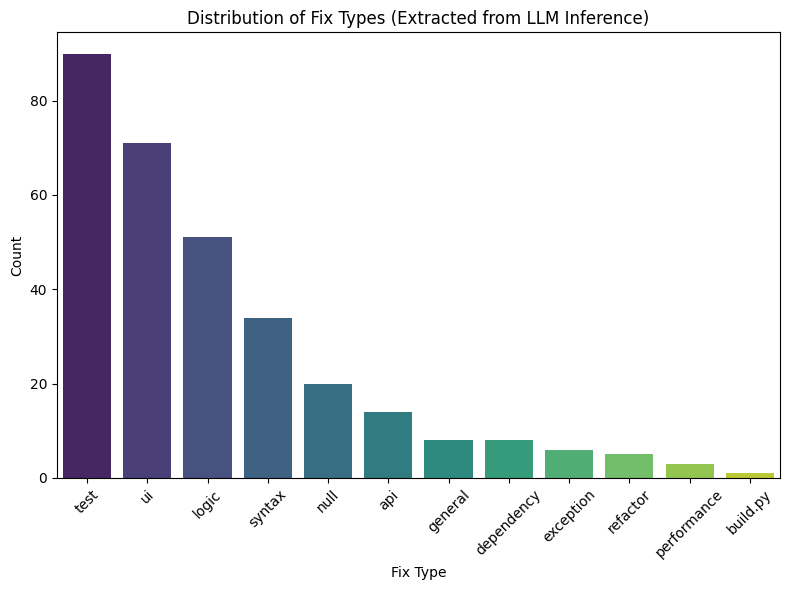

In [18]:
import matplotlib.pyplot as plt
import seaborn as sns
plt.figure(figsize=(8,6))
sns.barplot(x=fix_type_counts.index, y=fix_type_counts.values, palette="viridis")
plt.xticks(rotation=45)
plt.title("Distribution of Fix Types (Extracted from LLM Inference)")
plt.xlabel("Fix Type")
plt.ylabel("Count")
plt.tight_layout()
plt.show()

/tmp/ipykernel_63080/4191175063.py:2: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=extension_counts.index[:10], y=extension_counts.values[:10], palette="magma")


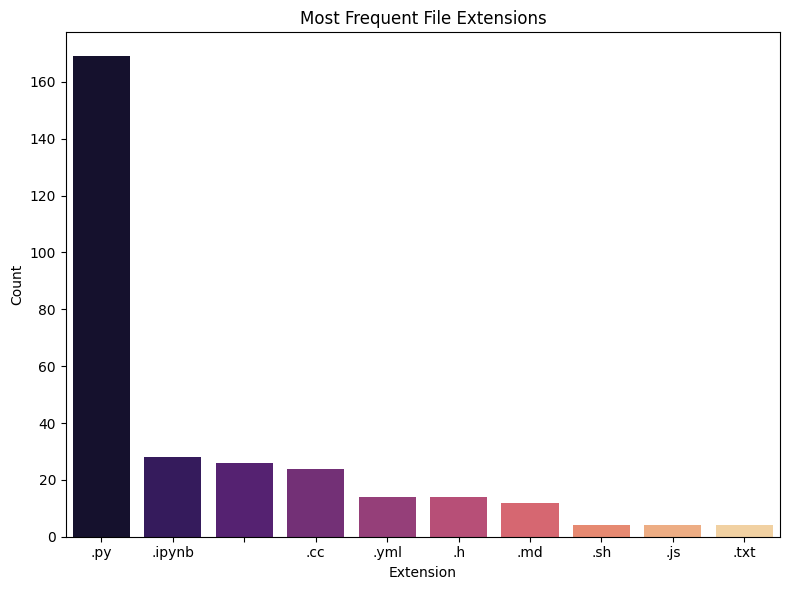

In [19]:
plt.figure(figsize=(8,6))
sns.barplot(x=extension_counts.index[:10], y=extension_counts.values[:10], palette="magma")
plt.title("Most Frequent File Extensions")
plt.xlabel("Extension")
plt.ylabel("Count")
plt.tight_layout()
plt.show()


In [ ]:
import re
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from radon.metrics import mi_visit
from radon.complexity import cc_visit
from radon.raw import analyze


In [ ]:

def clean_code(code):
    if pd.isna(code):
        return ""
    return str(code).replace("\\n", "\n").replace("\\t", "\t")

# --- Simple CC approximation for non-Python files or diffs ---
def approximate_cc(code):
    patterns = ["if", "for", "while", "case", "catch", "elif", "&&", "||", "?:"]
    return sum(len(re.findall(rf"\b{re.escape(kw)}\b", code)) for kw in patterns)

def compute_metrics(code, filename=None):
    code = clean_code(code)

    if not code.strip():
        return {"MI": 0, "CC": 0, "LOC": 0}

    try:
        if filename and filename.endswith(".py"):
            # Use radon for Python files
            mi_score = mi_visit(code, True)
            cc_blocks = cc_visit(code)
            cc_score = sum(block.complexity for block in cc_blocks) if cc_blocks else 0
            raw = analyze(code)
            loc_score = raw.loc
            return {"MI": mi_score, "CC": cc_score, "LOC": loc_score}
        else:
            # Non-Python → fallback
            loc_score = len(code.splitlines())
            cc_score = approximate_cc(code)
            return {"MI": 0, "CC": cc_score, "LOC": loc_score}
    except Exception:
        # If parsing fails → fallback
        loc_score = len(code.splitlines())
        cc_score = approximate_cc(code)
        return {"MI": 0, "CC": cc_score, "LOC": loc_score}

df_metrics = df.copy()

# Compute before metrics
df_metrics[['MI_Before','CC_Before','LOC_Before']] = df_metrics.apply(
    lambda row: pd.Series(compute_metrics(row['Source Code (before)'], row['Filename'])),
    axis=1
)

# Compute after metrics
df_metrics[['MI_After','CC_After','LOC_After']] = df_metrics.apply(
    lambda row: pd.Series(compute_metrics(row['Source Code (current)'], row['Filename'])),
    axis=1
)

# Compute changes
df_metrics['MI_Change'] = df_metrics['MI_After'] - df_metrics['MI_Before']
df_metrics['CC_Change'] = df_metrics['CC_After'] - df_metrics['CC_Before']
df_metrics['LOC_Change'] = df_metrics['LOC_After'] - df_metrics['LOC_Before']



In [41]:
# Save updated dataset
df_metrics.to_csv("lab3_structural_metrics.csv", index=False)
print("Metrics saved to lab3_structural_metrics.csv")



Metrics saved to lab3_structural_metrics.csv


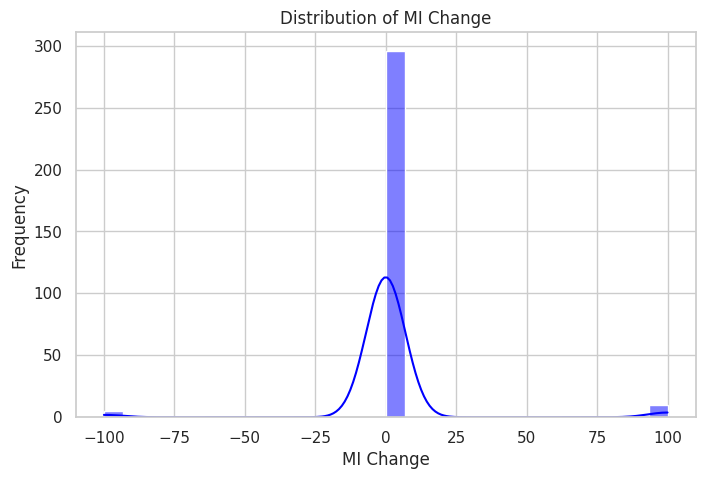

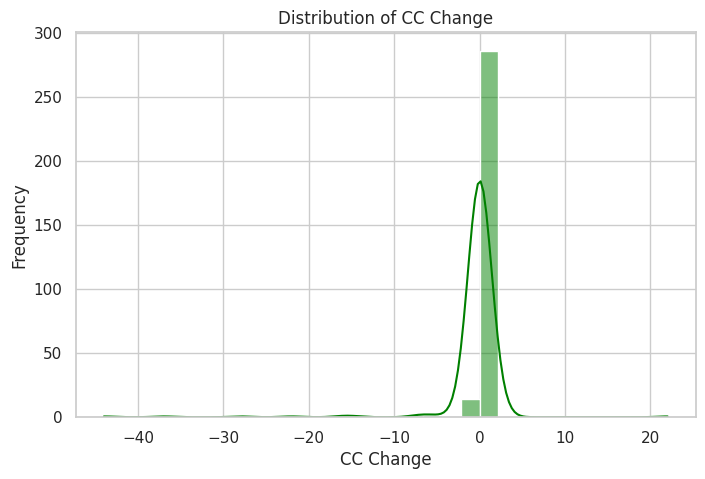

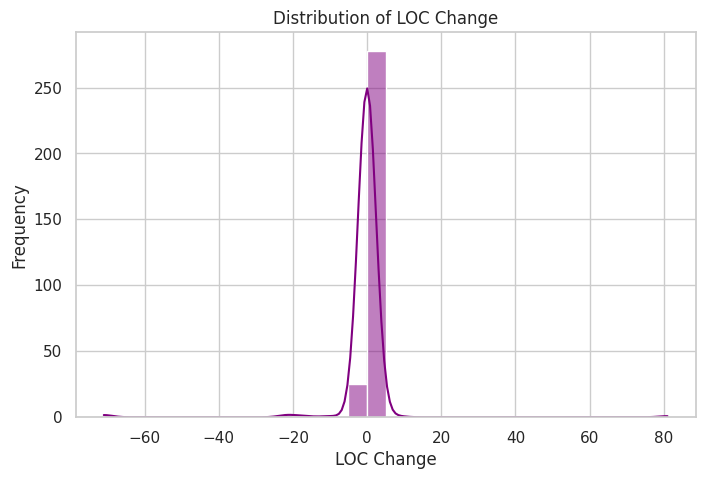

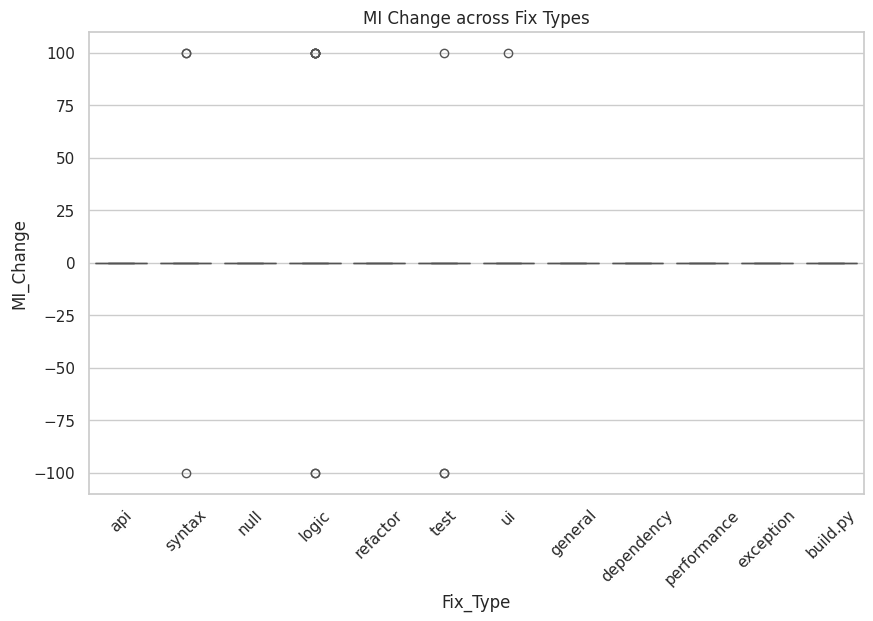

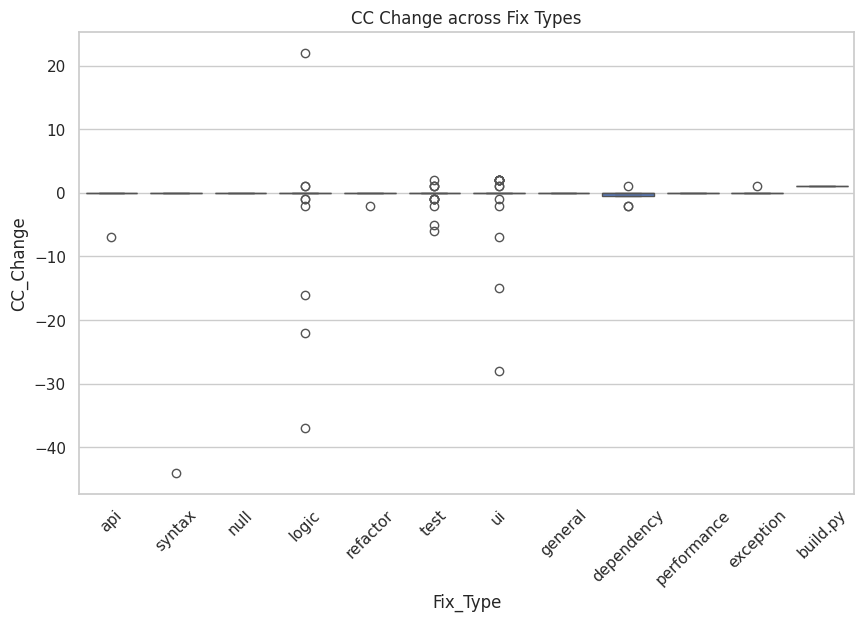

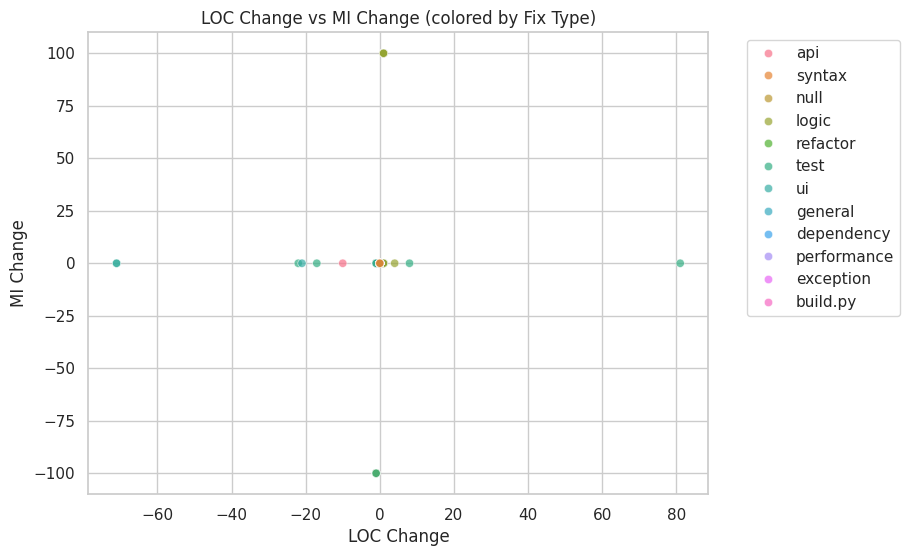

In [43]:
sns.set(style="whitegrid", palette="muted")

# Histogram of MI_Change
plt.figure(figsize=(8,5))
sns.histplot(df_metrics['MI_Change'], bins=30, kde=True, color="blue")
plt.title("Distribution of MI Change")
plt.xlabel("MI Change")
plt.ylabel("Frequency")
plt.show()

# Histogram of CC_Change
plt.figure(figsize=(8,5))
sns.histplot(df_metrics['CC_Change'], bins=30, kde=True, color="green")
plt.title("Distribution of CC Change")
plt.xlabel("CC Change")
plt.ylabel("Frequency")
plt.show()

# Histogram of LOC_Change
plt.figure(figsize=(8,5))
sns.histplot(df_metrics['LOC_Change'], bins=30, kde=True, color="purple")
plt.title("Distribution of LOC Change")
plt.xlabel("LOC Change")
plt.ylabel("Frequency")
plt.show()

# Boxplot: MI_Change by Fix_Type
plt.figure(figsize=(10,6))
sns.boxplot(x="Fix_Type", y="MI_Change", data=df_metrics)
plt.xticks(rotation=45)
plt.title("MI Change across Fix Types")
plt.show()

# Boxplot: CC_Change by Fix_Type
plt.figure(figsize=(10,6))
sns.boxplot(x="Fix_Type", y="CC_Change", data=df_metrics)
plt.xticks(rotation=45)
plt.title("CC Change across Fix Types")
plt.show()

# Scatterplot: LOC_Change vs MI_Change
plt.figure(figsize=(8,6))
sns.scatterplot(x="LOC_Change", y="MI_Change", data=df_metrics, hue="Fix_Type", alpha=0.7)
plt.title("LOC Change vs MI Change (colored by Fix Type)")
plt.xlabel("LOC Change")
plt.ylabel("MI Change")
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
plt.show()


In [44]:
import pandas as pd

# Assuming df_metrics already exists with Fix_Type, MI_Change, CC_Change, LOC_Change
summary_table = (
    df_metrics.groupby("Fix_Type")[["MI_Change", "CC_Change", "LOC_Change"]]
    .mean()
    .reset_index()
    .round(2)   # round for readability
)

print("Average Structural Metric Changes per Fix Type:\n")
print(summary_table.to_string(index=False))


Average Structural Metric Changes per Fix Type:

   Fix_Type  MI_Change  CC_Change  LOC_Change
        api       0.00      -0.50       -0.79
   build.py       0.00       1.00        1.00
 dependency       0.00      -0.38       -0.12
  exception       0.00       0.17        0.00
    general       0.00       0.00        0.00
      logic       7.84      -1.08        0.16
       null       0.00       0.00       -0.05
performance       0.00       0.00        0.00
   refactor       0.00      -0.40       -0.20
     syntax       2.94      -1.29        0.00
       test      -1.11      -0.14       -0.28
         ui       1.41      -0.49       -1.32


In [ ]:
import torch
import numpy as np
from transformers import AutoTokenizer, AutoModel
import sacrebleu

tokenizer = AutoTokenizer.from_pretrained("microsoft/codebert-base")
model = AutoModel.from_pretrained("microsoft/codebert-base")
device = "cuda" if torch.cuda.is_available() else "cpu"
model.to(device)

def get_embedding(code: str):
    if pd.isna(code) or not str(code).strip():
        return torch.zeros(768).to(device)
    tokens = tokenizer(code, return_tensors="pt", truncation=True, max_length=512).to(device)
    with torch.no_grad():
        outputs = model(**tokens)
    # Use mean pooling over last hidden state
    return outputs.last_hidden_state.mean(dim=1).squeeze()

def cosine_similarity(vec1, vec2):
    return torch.nn.functional.cosine_similarity(vec1.unsqueeze(0), vec2.unsqueeze(0)).item()

def compute_semantic_similarity(before, after):
    emb1 = get_embedding(before)
    emb2 = get_embedding(after)
    return cosine_similarity(emb1, emb2)

def compute_token_similarity(before, after):
    if pd.isna(before) or pd.isna(after):
        return 0.0
    bleu = sacrebleu.corpus_bleu([after], [[before]])
    return bleu.score / 100.0   # Normalize to 0–1


/home/vedant/miniconda3/envs/stt/lib/python3.13/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [46]:
df_metrics['Semantic_Similarity'] = df_metrics.apply(
    lambda row: compute_semantic_similarity(row['Source Code (before)'], row['Source Code (current)']),
    axis=1
)

df_metrics['Token_Similarity'] = df_metrics.apply(
    lambda row: compute_token_similarity(row['Source Code (before)'], row['Source Code (current)']),
    axis=1
)

In [48]:
df_metrics.to_csv("lab3_with_similarity.csv", index=False)
print(" Added Semantic_Similarity and Token_Similarity to lab3_with_similarity.csv")

 Added Semantic_Similarity and Token_Similarity to lab3_with_similarity.csv


In [49]:
def classify_semantic(similarity, threshold=0.80):
    return "Minor" if similarity >= threshold else "Major"

def classify_token(similarity, threshold=0.75):
    return "Minor" if similarity >= threshold else "Major"

df_metrics["Semantic_Class"] = df_metrics["Semantic_Similarity"].apply(classify_semantic)
df_metrics["Token_Class"] = df_metrics["Token_Similarity"].apply(classify_token)

df_metrics["Classes_Agree"] = df_metrics.apply(
    lambda row: "YES" if row["Semantic_Class"] == row["Token_Class"] else "NO",
    axis=1
)

df_metrics.to_csv("lab3_with_classifications.csv", index=False)
print("Classification & Agreement columns added and saved to lab3_with_classifications.csv")

print("\n🔹 Semantic Classification Counts:\n", df_metrics["Semantic_Class"].value_counts())
print("\n🔹 Token Classification Counts:\n", df_metrics["Token_Class"].value_counts())
print("\n🔹 Agreement Check:\n", df_metrics["Classes_Agree"].value_counts())

Classification & Agreement columns added and saved to lab3_with_classifications.csv

🔹 Semantic Classification Counts:
 Semantic_Class
Minor    254
Major     57
Name: count, dtype: int64

🔹 Token Classification Counts:
 Token_Class
Minor    234
Major     77
Name: count, dtype: int64

🔹 Agreement Check:
 Classes_Agree
YES    291
NO      20
Name: count, dtype: int64


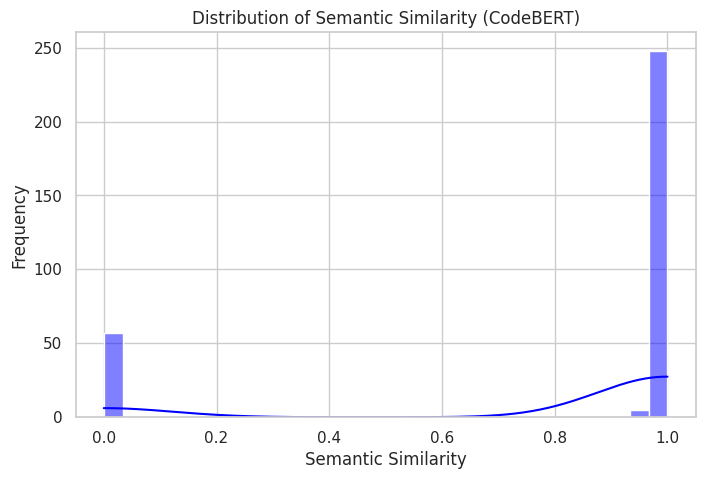

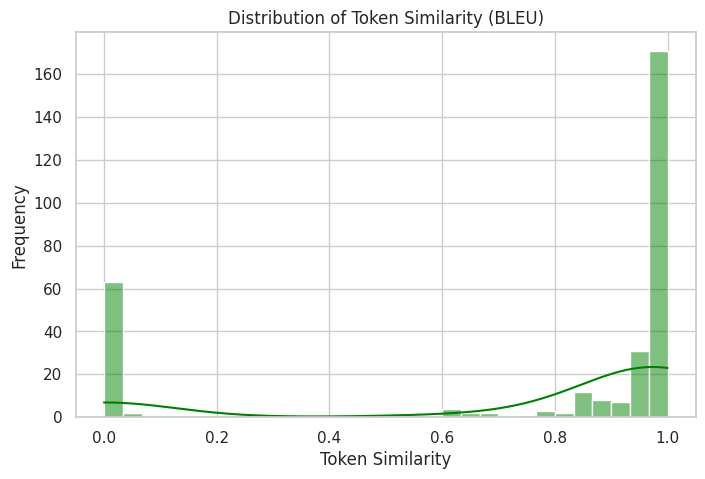

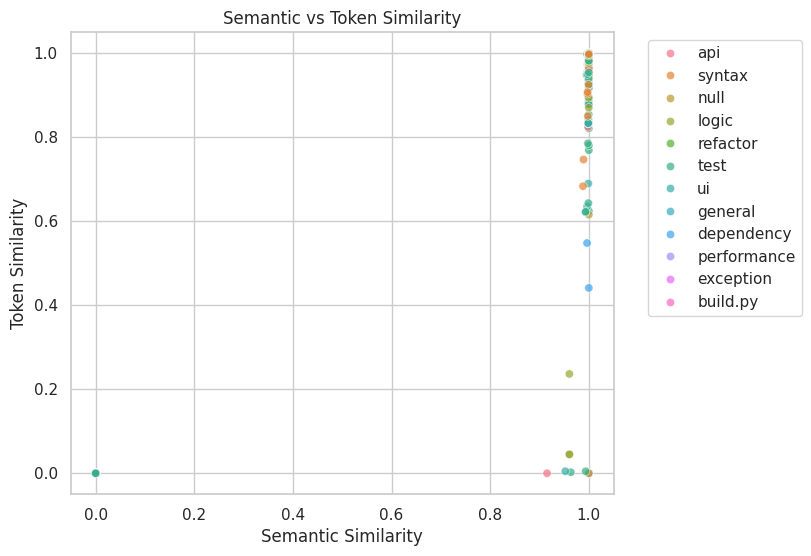

In [50]:
import matplotlib.pyplot as plt
import seaborn as sns

# Histogram of Semantic Similarity
plt.figure(figsize=(8,5))
sns.histplot(df_metrics["Semantic_Similarity"], bins=30, kde=True, color="blue")
plt.title("Distribution of Semantic Similarity (CodeBERT)")
plt.xlabel("Semantic Similarity")
plt.ylabel("Frequency")
plt.show()

# Histogram of Token Similarity
plt.figure(figsize=(8,5))
sns.histplot(df_metrics["Token_Similarity"], bins=30, kde=True, color="green")
plt.title("Distribution of Token Similarity (BLEU)")
plt.xlabel("Token Similarity")
plt.ylabel("Frequency")
plt.show()

# Scatterplot: Semantic vs Token Similarity
plt.figure(figsize=(7,6))
sns.scatterplot(x="Semantic_Similarity", y="Token_Similarity", data=df_metrics, alpha=0.7, hue="Fix_Type")
plt.title("Semantic vs Token Similarity")
plt.xlabel("Semantic Similarity")
plt.ylabel("Token Similarity")
plt.legend(bbox_to_anchor=(1.05, 1), loc="upper left")
plt.show()


/tmp/ipykernel_63080/391307937.py:3: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(x="Semantic_Class", data=df_metrics, palette="Blues", order=["Major","Minor"])


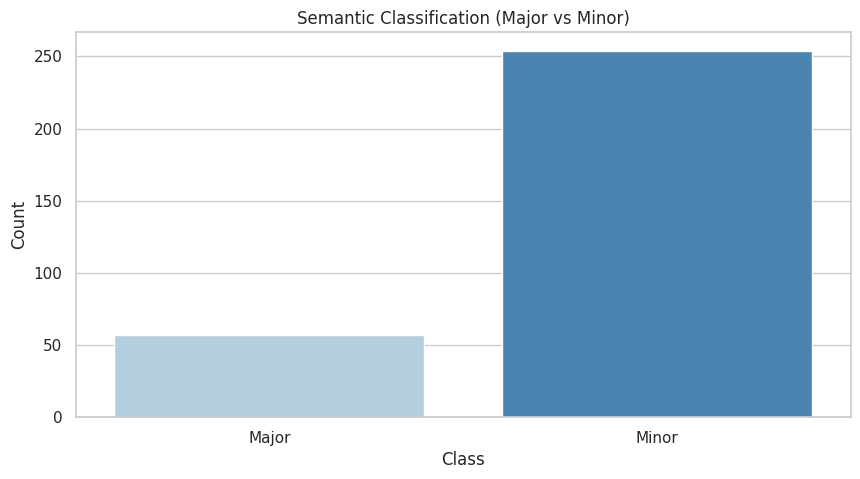

/tmp/ipykernel_63080/391307937.py:10: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(x="Token_Class", data=df_metrics, palette="Greens", order=["Major","Minor"])


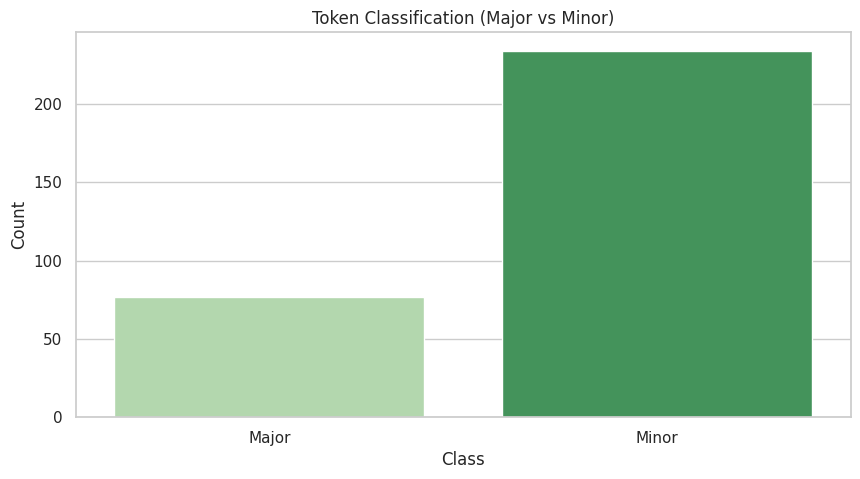

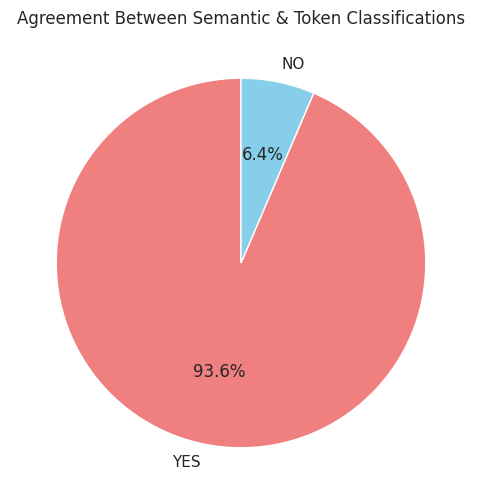

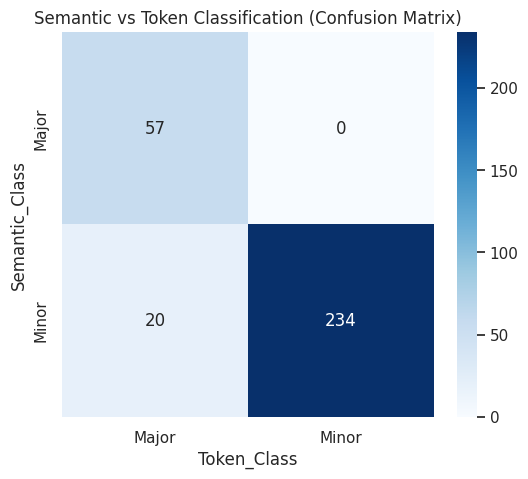

In [51]:
# Bar plot for Semantic vs Token Classification Counts
plt.figure(figsize=(10,5))
sns.countplot(x="Semantic_Class", data=df_metrics, palette="Blues", order=["Major","Minor"])
plt.title("Semantic Classification (Major vs Minor)")
plt.xlabel("Class")
plt.ylabel("Count")
plt.show()

plt.figure(figsize=(10,5))
sns.countplot(x="Token_Class", data=df_metrics, palette="Greens", order=["Major","Minor"])
plt.title("Token Classification (Major vs Minor)")
plt.xlabel("Class")
plt.ylabel("Count")
plt.show()

# Agreement Pie Chart
plt.figure(figsize=(6,6))
df_metrics["Classes_Agree"].value_counts().plot.pie(
    autopct="%1.1f%%", startangle=90, colors=["lightcoral","skyblue"], labels=["YES","NO"]
)
plt.title("Agreement Between Semantic & Token Classifications")
plt.ylabel("")
plt.show()

# Heatmap: Agreement Matrix
plt.figure(figsize=(6,5))
conf_matrix = pd.crosstab(df_metrics["Semantic_Class"], df_metrics["Token_Class"])
sns.heatmap(conf_matrix, annot=True, fmt="d", cmap="Blues")
plt.title("Semantic vs Token Classification (Confusion Matrix)")
plt.show()


In [52]:
df_metrics.head()

,Hash,Message,Filename,Source Code (before),Source Code (current),Diff,LLM Inference (fix type),Rectified Message,Fix_Type,LOC_Before,...,MI_Before,MI_After,LOC_Change,CC_Change,MI_Change,Semantic_Similarity,Token_Similarity,Semantic_Class,Token_Class,Classes_Agree
0,72acd20fe3cf5d1ffa55fd0bcbb01956bf66fa23,Fix typo in notebook fonction->function,spherical_harmonics_approximation.ipynb,"{ ""cells"": [ { ""cell_type"": ""markd...","{ ""cells"": [ { ""cell_type"": ""markd...","@@ -67,12 +67,12 @@ ""lighting is\n"", ...",fix typo in spherical harmonics approximation(...,fix typo in spherical harmonics approximation,api,404.0,...,0.0,0.0,0.0,0.0,0.0,1.000000,0.999435,Minor,Minor,YES
1,8c34bd6af580752daae0548a5a74be932b2cc619,Replaces the gamma parameter from sRGB functio...,constants.py,#Copyright 2018 Google LLC # # Licensed under ...,#Copyright 2018 Google LLC # # Licensed under ...,"@@ -20,4 +20,4 @@ from __future__ import print...",fix broken test(syntax),fix broken test,syntax,1.0,...,100.0,100.0,0.0,0.0,0.0,0.999789,0.969237,Minor,Minor,YES
2,8c34bd6af580752daae0548a5a74be932b2cc619,Replaces the gamma parameter from sRGB functio...,linear_rgb.py,#Copyright 2018 Google LLC # # Licensed under ...,#Copyright 2018 Google LLC # # Licensed under ...,"@@ -28,17 +28,10 @@ from tensorflow_graphics.u...",fix missing file(null),fix missing file,null,1.0,...,100.0,100.0,0.0,0.0,0.0,0.998759,0.835113,Minor,Minor,YES
3,8c34bd6af580752daae0548a5a74be932b2cc619,Replaces the gamma parameter from sRGB functio...,srgb.py,#Copyright 2018 Google LLC # # Licensed under ...,#Copyright 2018 Google LLC # # Licensed under ...,"@@ -34,9 +34,10 @@ from tensorflow_graphics.ut...",update src/index.py(null),update src/index.py,null,1.0,...,100.0,100.0,0.0,0.0,0.0,0.999683,0.972297,Minor,Minor,YES
4,cd8c42f9ca260f77c6acfecd42e66ef01d1a3766,Fix data processing error: https://github.com/...,array-buffer-data-provider.js,/* Copyright 2019 The TensorFlow Authors. All...,/* Copyright 2019 The TensorFlow Authors. All...,"@@ -23,6 +23,14 @@ limitations under the Licen...",fix missing file(api),fix missing file,api,1.0,...,0.0,0.0,0.0,0.0,0.0,0.999477,0.965154,Minor,Minor,YES
